##### Problem Statement

Identify patterns/seasonality/trends in raw stock data inputs as well as accurately predict future stock prices in order to provide profitable investing insights to investors to achieve a solid ROI while minimizing their MAPE. Accurately determine the best performing stocks over specific time periods and locate best potential times to enter mid to long to positions (holding for weeks-to-years rather than day trading). (As MAPE decreases, ROI naturally increases)

##### Business Value

Identifying highest upside stocks with the lowest amount of risk to provide new investors with safe but rewarding returns on their investments.  Looking at ROI of the stocks, and MAPE of our models to identify which stocks are most profitable, and which can be most accurately predicted, and thus more often realizing positive returns.  (Identifying trends in data such as best months to buy, worst months to buy, best potential time periods to hold...i.e when to get in/out).  Also reassuring investors that the technical analysis speaks for itself, and not to get caught up in the news cycles.

Going to use ARIMA models based on past information in a time series to predict future stock prices.

In [1]:
import datetime as dt
from functools import reduce
import math
from math import sqrt
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import scipy.stats as st

# Obtain

In [2]:
df_amazon = pd.read_csv(r"C:\Users\Nick\Desktop\Amazon.csv")
df_apple = pd.read_csv(r"C:\Users\Nick\Desktop\Apple.csv")
df_netflix = pd.read_csv(r"C:\Users\Nick\Desktop\Netflix.csv")
df_google = pd.read_csv(r"C:\Users\Nick\Desktop\Google.csv")
df_facebook = pd.read_csv(r"C:\Users\Nick\Desktop\Facebook.csv")

##### Assign company name to series values

In [3]:
amazon_list = ['AMZN' for i in range(df_amazon.shape[0])]
df_amazon['Company Name'] = amazon_list

In [4]:
apple_list = ['AAPL' for i in range(df_apple.shape[0])]
df_apple['Company Name'] = apple_list

In [5]:
netflix_list = ['NFLX' for i in range(df_netflix.shape[0])]
df_netflix['Company Name'] = netflix_list

In [6]:
google_list = ['GOOGL' for i in range(df_google.shape[0])]
df_google['Company Name'] = google_list

In [7]:
facebook_list = ['FB' for i in range(df_facebook.shape[0])]
df_facebook['Company Name'] = facebook_list

# Explore

#### Convert 'Date' column to datetimes

In [8]:
# Create function for this below
#  date_name, month_col, year_col, 

def convert_datetime(df):
        '''
        This function converts columns for separate intervals of time.

        Args:
        * df: amazon, apple, google, netflix, facebook

        Returns:
        * df: The output dataframe with columns for each time interval.
        '''
        df['Date'] = pd.to_datetime(df["Date"], errors = 'coerce')
        df['month'] = df['Date'].dt.month
        df['year'] = df['Date'].dt.year
        df['week'] = df['Date'].dt.week
        return df

# convert each dataframe
convert_datetime(df_amazon)
convert_datetime(df_apple)
convert_datetime(df_google)
convert_datetime(df_netflix)
convert_datetime(df_facebook)

,Date,Open,High,Low,Close,Adj Close,Volume,Company Name,month,year,week
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400,FB,5,2012,20
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700,FB,5,2012,21
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600,FB,5,2012,21
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000,FB,5,2012,21
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200,FB,5,2012,21
...,...,...,...,...,...,...,...,...,...,...,...
2071,2020-08-12,258.970001,263.899994,258.109985,259.890015,259.890015,21428300,FB,8,2020,33
2072,2020-08-13,261.549988,265.160004,259.570007,261.299988,261.299988,17374000,FB,8,2020,33
2073,2020-08-14,262.309998,262.649994,258.679993,261.239990,261.239990,14792700,FB,8,2020,33
2074,2020-08-17,262.500000,264.100006,259.399994,261.160004,261.160004,13351100,FB,8,2020,34


In [9]:
df_faang = pd.concat([df_amazon, df_apple, df_google, df_netflix, df_facebook])

df_faang.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26566 entries, 0 to 2075
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          26566 non-null  datetime64[ns]
 1   Open          26565 non-null  float64       
 2   High          26565 non-null  float64       
 3   Low           26565 non-null  float64       
 4   Close         26565 non-null  float64       
 5   Adj Close     26565 non-null  float64       
 6   Volume        26565 non-null  float64       
 7   Company Name  26566 non-null  object        
 8   month         26566 non-null  int64         
 9   year          26566 non-null  int64         
 10  week          26566 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 2.4+ MB


Look to see if anything stands out in dataframes from raw closing prices/volume.

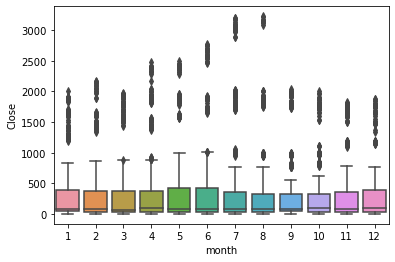

In [10]:
# amazon
sns.boxplot(x="month", y="Close", data=df_amazon)

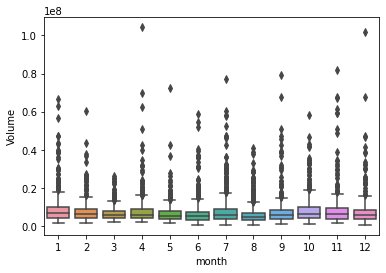

In [11]:
# amazon
sns.boxplot(x="month", y="Volume", data=df_amazon)

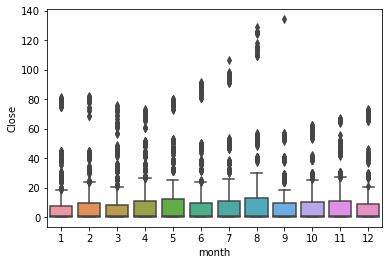

In [12]:
# apple
sns.boxplot(x="month", y="Close", data=df_apple)

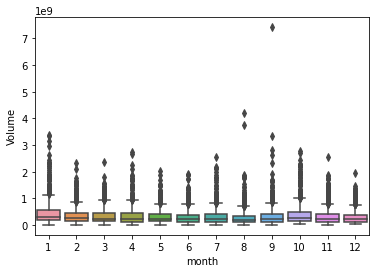

In [13]:
# apple
sns.boxplot(x="month", y="Volume", data=df_apple)

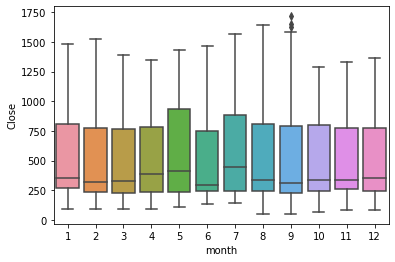

In [14]:
# google
sns.boxplot(x="month", y="Close", data=df_google)

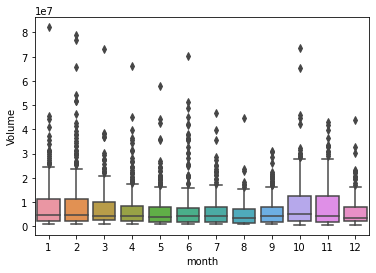

In [15]:
# google
sns.boxplot(x="month", y="Volume", data=df_google)

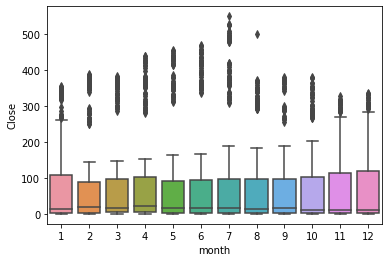

In [16]:
# netflix
sns.boxplot(x="month", y="Close", data=df_netflix)

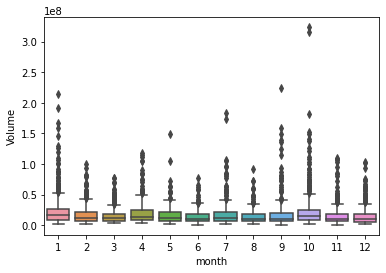

In [17]:
# netflix
sns.boxplot(x="month", y="Volume", data=df_netflix)

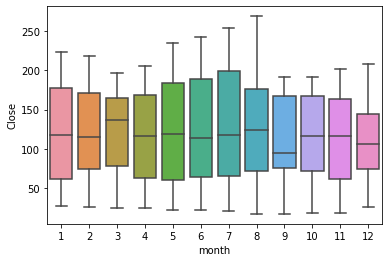

In [18]:
# facebook
sns.boxplot(x="month", y="Close", data=df_facebook)

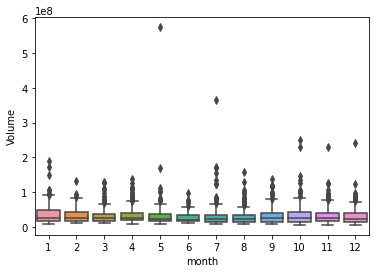

In [19]:
# facebook
sns.boxplot(x="month", y="Volume", data=df_facebook)

#### Create concatenated database

In [20]:
df_faang = pd.concat([df_amazon, df_apple, df_google, df_netflix, df_facebook])

df_faang


,Date,Open,High,Low,Close,Adj Close,Volume,Company Name,month,year,week
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,AMZN,5,1997,20
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,AMZN,5,1997,20
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,AMZN,5,1997,21
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0,AMZN,5,1997,21
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0,AMZN,5,1997,21
...,...,...,...,...,...,...,...,...,...,...,...
2071,2020-08-12,258.970001,263.899994,258.109985,259.890015,259.890015,21428300.0,FB,8,2020,33
2072,2020-08-13,261.549988,265.160004,259.570007,261.299988,261.299988,17374000.0,FB,8,2020,33
2073,2020-08-14,262.309998,262.649994,258.679993,261.239990,261.239990,14792700.0,FB,8,2020,33
2074,2020-08-17,262.500000,264.100006,259.399994,261.160004,261.160004,13351100.0,FB,8,2020,34


#### Use 'groupby' function to group data into weekly/monthly/yearly periods

In [21]:
### write function for below

def week_month_year_converter(time_interval):
    '''
    This function takes the mean after grouping by the selected time interval
    and restricts the time interval to 2012-onwards.

    Args:
    * time_interval: 'Week', 'Month', or 'Year'

    Returns:
    * output_df: The output dataframe. Mean close values.
    '''
    close_col_name = time_interval + "ly Mean Close"
    if time_interval == 'Week':
        col_list = ['Company Name', 
                    'year', 
                    'month', 
                    'week'
                   ]
    if time_interval == 'Month':
        col_list = ['Company Name', 
                    'year', 
                    'month'
                   ]
    if time_interval == 'Year':
        col_list = ['Company Name', 
                    'year'
                   ]    
    output_df = df_faang.groupby(by=col_list)['Close'].mean().reset_index()
    output_df = output_df.rename(columns={'Close':close_col_name})
    output_df = output_df[output_df['year']>=2012].copy(deep=True)
    
    return output_df


In [22]:
df_faang_weekly_2012OW = week_month_year_converter('Week')
df_faang_monthly_2012OW = week_month_year_converter('Month')
df_faang_yearly_2012OW = week_month_year_converter('Year')

In [23]:
df_faang_weekly_2012OW.head(400)

,Company Name,year,month,week,Weekly Mean Close
1822,AAPL,2012,1,1,14.866964
1823,AAPL,2012,1,2,15.062286
1824,AAPL,2012,1,3,15.195179
1825,AAPL,2012,1,4,15.617071
1826,AAPL,2012,1,5,16.240892
...,...,...,...,...,...
2217,AAPL,2018,9,38,54.609000
2218,AAPL,2018,9,39,55.704500
2219,AAPL,2018,10,40,57.044500
2220,AAPL,2018,10,41,55.178000


In [24]:
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'])
df_amazon = df_amazon.set_index('Date')

In [25]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple = df_apple.set_index('Date')

In [26]:
df_google['Date'] = pd.to_datetime(df_google['Date'])
df_google = df_google.set_index('Date')

In [27]:
df_netflix['Date'] = pd.to_datetime(df_netflix['Date'])
df_netflix = df_netflix.set_index('Date')

In [28]:
df_facebook['Date'] = pd.to_datetime(df_facebook['Date'])
df_facebook = df_facebook.set_index('Date')

In [29]:
### resample data

df_amazon_week_sample = df_amazon.resample('W-MON').mean()
df_amazon_week_sample = df_amazon_week_sample[df_amazon_week_sample[
    'year']>=2012].copy(deep=True)

df_apple_week_sample = df_apple.resample('W-MON').mean()
df_apple_week_sample = df_apple_week_sample[df_apple_week_sample[
    'year']>=2012].copy(deep=True)

df_google_week_sample = df_google.resample('W-MON').mean()
df_google_week_sample = df_google_week_sample[df_google_week_sample[
    'year']>=2012].copy(deep=True)

df_netflix_week_sample = df_netflix.resample('W-MON').mean()
df_netflix_week_sample = df_netflix_week_sample[df_netflix_week_sample[
    'year']>=2012].copy(deep=True)

df_facebook_week_sample = df_facebook.resample('W-MON').mean()
df_facebook_week_sample = df_facebook_week_sample[df_facebook_week_sample[
    'year']>=2012].copy(deep=True)


In [30]:
### creating weeklydata using .groupby method

weekly_data_table = df_amazon.reset_index()

weekly_data_table = weekly_data_table[['Date', 'month', 'year', 'week']]
weekly_data_gb = weekly_data_table.groupby(by=['year',
                                               'month',
                                               'week'])['Date'].min()
weekly_data_gb.reset_index()

df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW.merge(weekly_data_gb, 
                                                            on=['year', 
                                                                'month', 
                                                                'week'], 
                                                            how='left')

df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated.rename(
    columns={'Date': 
        'Start of Week'})

### amazon
amazon_df_faang_weekly_2012OW_dated = (
    df_faang_weekly_2012OW_dated[
        df_faang_weekly_2012OW_dated['Company Name']=='AMZN']
    .copy(deep=True)
)
amazon_df_faang_weekly_2012OW_dated = (
    amazon_df_faang_weekly_2012OW_dated.set_index('Start of Week'))

### apple
apple_df_faang_weekly_2012OW_dated = (
    df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated[
        'Company Name']=='AAPL'].copy(deep=True)
)
apple_df_faang_weekly_2012OW_dated = (
    apple_df_faang_weekly_2012OW_dated[apple_df_faang_weekly_2012OW_dated[
        'Start of Week']==apple_df_faang_weekly_2012OW_dated[
        'Start of Week']]
)
apple_df_faang_weekly_2012OW_dated = (
    apple_df_faang_weekly_2012OW_dated.set_index('Start of Week')
)

### google
google_df_faang_weekly_2012OW_dated = (
    df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated[
        'Company Name']=='GOOGL'].copy(deep=True)
)
google_df_faang_weekly_2012OW_dated = (
    google_df_faang_weekly_2012OW_dated[google_df_faang_weekly_2012OW_dated[
        'Start of Week']==google_df_faang_weekly_2012OW_dated[
        'Start of Week']]
)
google_df_faang_weekly_2012OW_dated = (
    google_df_faang_weekly_2012OW_dated.set_index('Start of Week'))

### netflix
netflix_df_faang_weekly_2012OW_dated = (
    df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated[
        'Company Name']=='NFLX'].copy(deep=True)
)
netflix_df_faang_weekly_2012OW_dated = (
    netflix_df_faang_weekly_2012OW_dated.set_index('Start of Week'))

### facebook
facebook_df_faang_weekly_2012OW_dated = (
    df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated[
        'Company Name']=='FB'].copy(deep=True)
)
facebook_df_faang_weekly_2012OW_dated = (
    facebook_df_faang_weekly_2012OW_dated[
        facebook_df_faang_weekly_2012OW_dated[
            'Start of Week']==facebook_df_faang_weekly_2012OW_dated[
            'Start of Week']]
)
facebook_df_faang_weekly_2012OW_dated = (
    facebook_df_faang_weekly_2012OW_dated.set_index('Start of Week')
)


#### Setting period to 52 to see yearly data

In [31]:
### decompositions

def seasonal_decomp(ts, period=52):
    '''
    This function takes in values from a series and returns a decomposition
    with a yearly period in order to check for seasonality/trends.

    Args:
    * ts: time series
    * period: sets default time period to 52 (yearly)

    Returns:
    * decomposition_plot: plotting matrix that shows trend/seasonality/white noise.
    '''
    ts = pd.Series(ts['Weekly Mean Close'].values)
    decomposition_ts = seasonal_decompose(ts, period=52)
    decomposition_ts.plot();


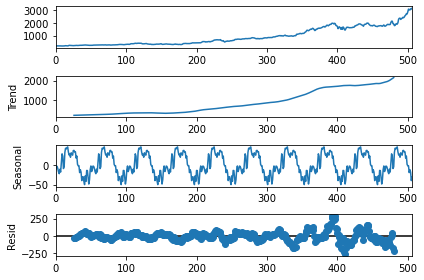

In [32]:
# amazon
seasonal_decomp(amazon_df_faang_weekly_2012OW_dated)

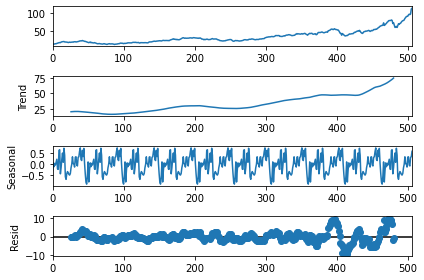

In [33]:
# apple
seasonal_decomp(apple_df_faang_weekly_2012OW_dated)

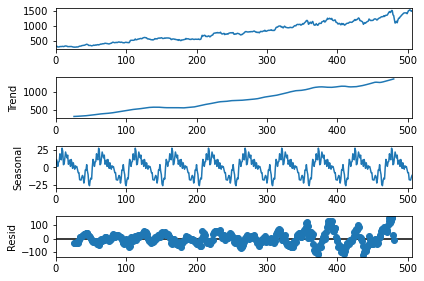

In [34]:
# google
seasonal_decomp(google_df_faang_weekly_2012OW_dated)

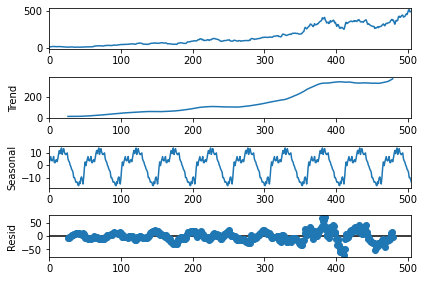

In [35]:
# netflix
seasonal_decomp(netflix_df_faang_weekly_2012OW_dated)

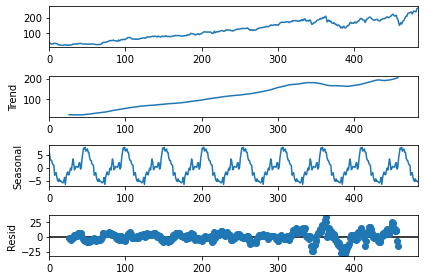

In [36]:
# facebook
seasonal_decomp(facebook_df_faang_weekly_2012OW_dated)

#### Testing for stationarity using ADF

In [37]:
### Creating function to plot rolling mean/std of df
def plot_rolling(df, date_col, close_col, ROLL=13):
    '''
    This function plots the weekly mean close, rolling mean, 
    and rolling std deviation for each dataframe given.

    Args:
    * df: df's with weekly mean close, rolling mean, rolling std dev
    * date_col: set weekly parameter
    * close_col: set mean close column
    * ROLL: set default ROLL to 13 for quarterly view

    Returns:
    * plot: plot with different colors for each rolling data.
    '''

    try:
        test = df[date_col]
    except:
        df = df.reset_index()
    
    # create rolling mean and std columns for data
    df['rolling_mean'] = df[close_col].rolling(window=ROLL).mean()
    df['rolling_std'] = df[close_col].rolling(window=ROLL).std()

    # plot data
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(df[date_col], 
        df[close_col], 
        color='red', 
        label=close_col)
    ax.plot(df[date_col], 
        df['rolling_mean'], 
        color='black', 
        label='Rolling Mean')
    ax.plot(df[date_col], 
        df['rolling_std'], 
        color='blue', 
        label='Rolling Std')
    ax.legend()
    fig.tight_layout()

##### Amazon rolling plot

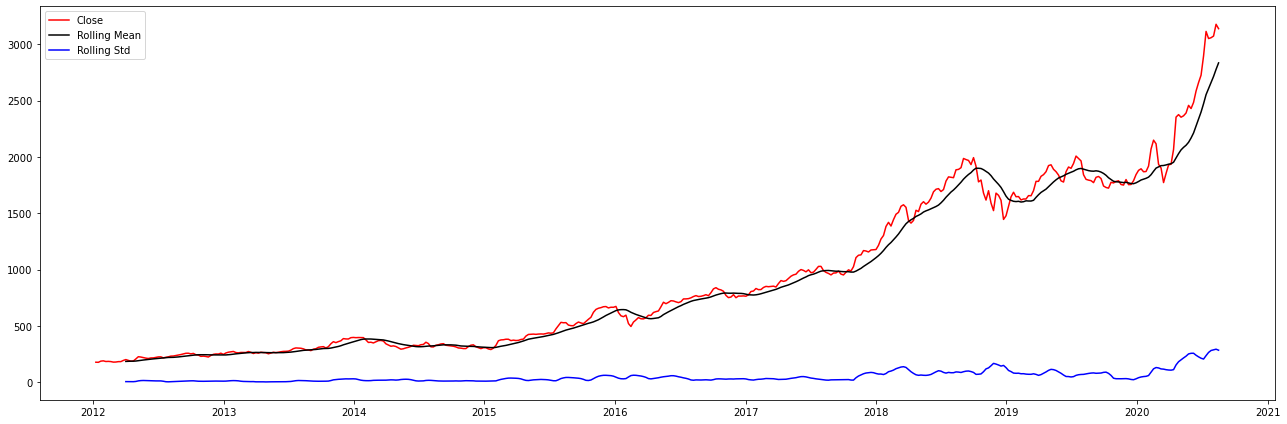

In [38]:
plot_rolling(df_amazon_week_sample, 'Date', 'Close')

##### Apple rolling plot

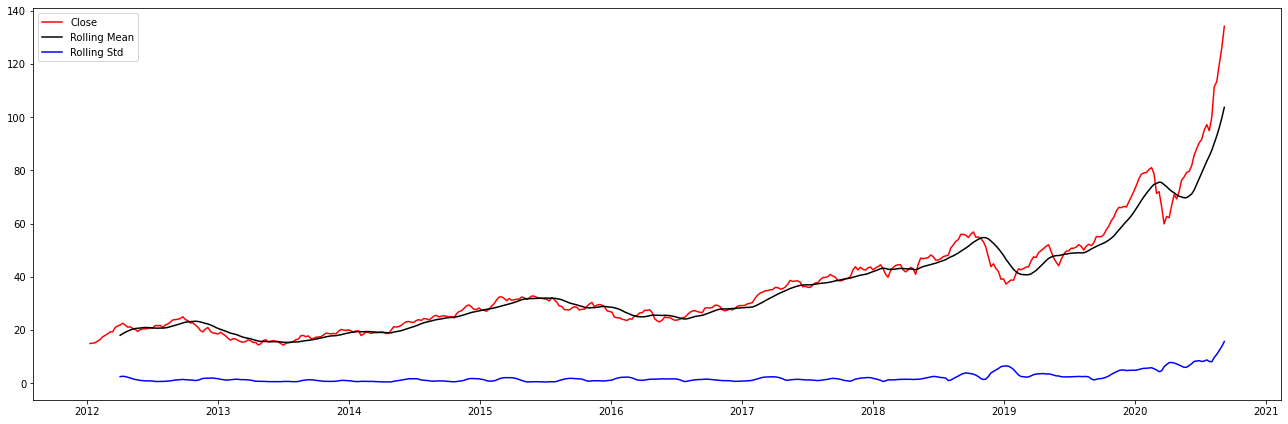

In [39]:
plot_rolling(df_apple_week_sample, 'Date', 'Close')

##### Google rolling plot

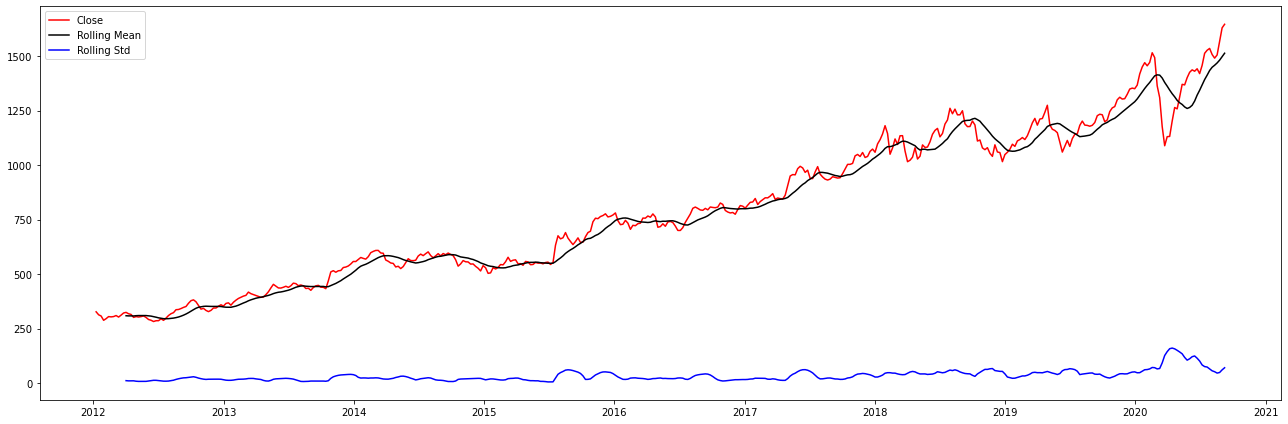

In [40]:
plot_rolling(df_google_week_sample, 'Date', 'Close')

##### Netflix rolling plot

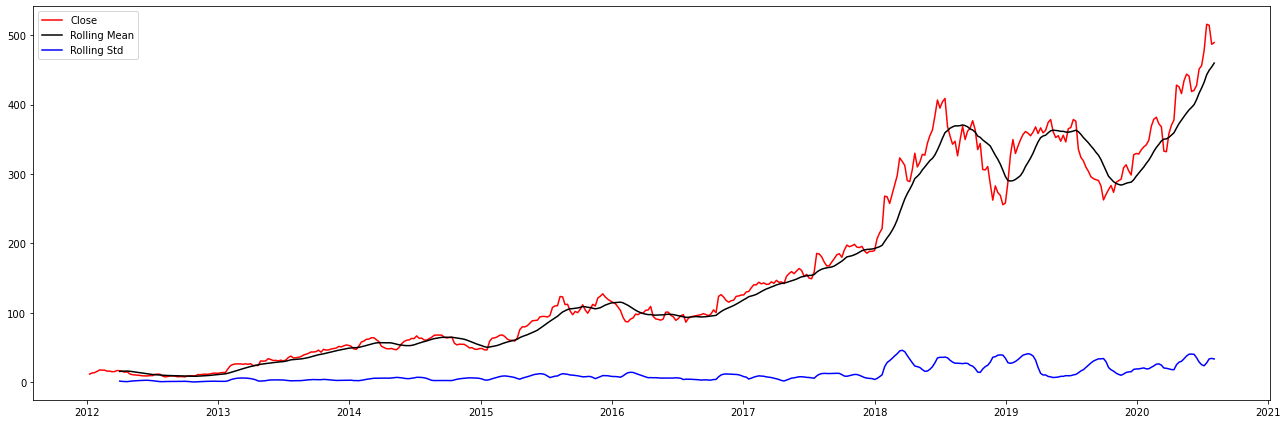

In [41]:
plot_rolling(df_netflix_week_sample, 'Date', 'Close')

##### Facebook rolling plot

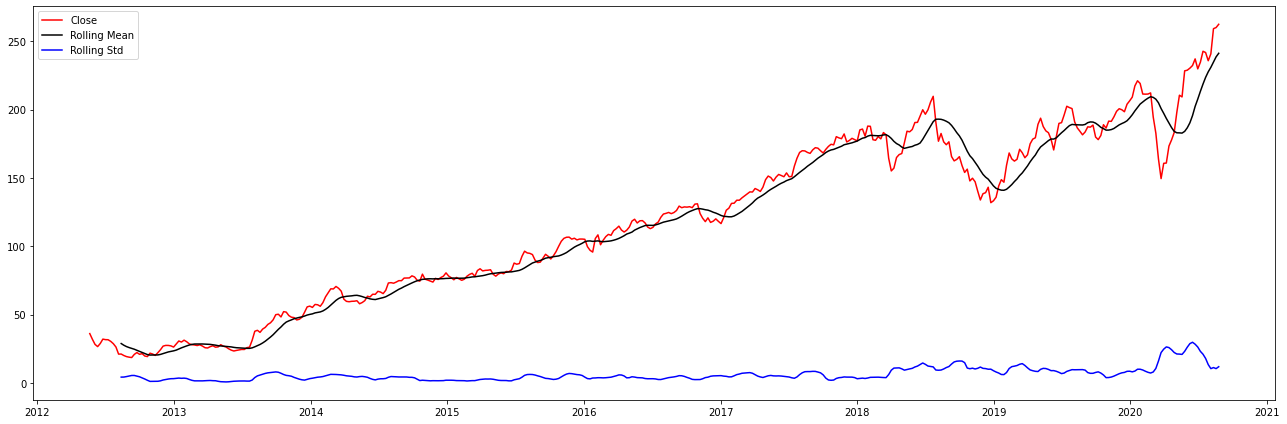

In [42]:
plot_rolling(df_facebook_week_sample, 'Date', 'Close')

#### Dickey-Fuller Testing

In [43]:
### The following block is modified from Claude Fried's Lesson on Time Series
### Create function to read out adfuller information clearly.

def adfuller_test(series):
    '''
    This function performs an adfuller test on a given time series.

    Args:
    * series: time series

    Returns:
    * adfuller results: shows adf test result, pvalue, used lag, nobs,
    crit_vals.
    * resstore: stores the adfuller for the series
    '''    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                            ADF: {adf}
                        P-value: {pvalue}
                       Used Lag: {usedlag}
         Number of Observations: {nobs}
      Critical Values (for ADP): {crit_vals}
                    ResultStore: {resstore}
         ''')

In [44]:
print('AMZN')
adfuller_test(amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('AAPL')
adfuller_test(apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('GOOGL')
adfuller_test(google_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('NFLX')
adfuller_test(netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('FB')
adfuller_test(facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

AMZN

                            ADF: 1.898502766675003
                        P-value: 0.9985256062984472
                       Used Lag: 15
         Number of Observations: 491
      Critical Values (for ADP): {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}
                    ResultStore: 4977.525190588249
         
AAPL

                            ADF: 2.8834783564753286
                        P-value: 1.0
                       Used Lag: 18
         Number of Observations: 488
      Critical Values (for ADP): {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
                    ResultStore: 1691.7736276044911
         
GOOGL

                            ADF: 0.4614964274354416
                        P-value: 0.9836546139957308
                       Used Lag: 19
         Number of Observations: 487
      Critical Values (for ADP): {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}

The p-value's for the time series above are all very close to 1.  We fail to reject the null hypothesis, and can determine that the time series aren't stationary.

#### De-trending the time series

In [45]:
amazon_df_faang_weekly_2012OW_dated['Close_Detrend'] = (amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
apple_df_faang_weekly_2012OW_dated['Close_Detrend'] = (apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
google_df_faang_weekly_2012OW_dated['Close_Detrend'] = (google_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - google_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
netflix_df_faang_weekly_2012OW_dated['Close_Detrend'] = (netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
facebook_df_faang_weekly_2012OW_dated['Close_Detrend'] = (facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))


                            ADF: -3.5655584319198557
                        P-value: 0.006454660696658872
                       Used Lag: 14
         Number of Observations: 491
      Critical Values (for ADP): {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}
                    ResultStore: 4979.354134385538
         


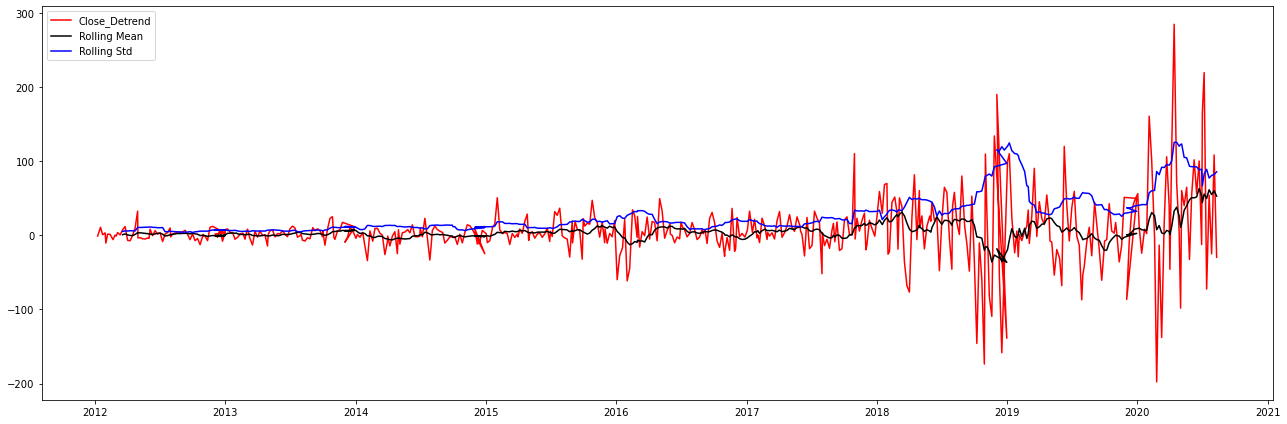

In [46]:
### amazon
adfuller_test(amazon_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(amazon_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -2.9941013370823306
                        P-value: 0.0354489451886579
                       Used Lag: 17
         Number of Observations: 488
      Critical Values (for ADP): {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
                    ResultStore: 1698.301926846657
         


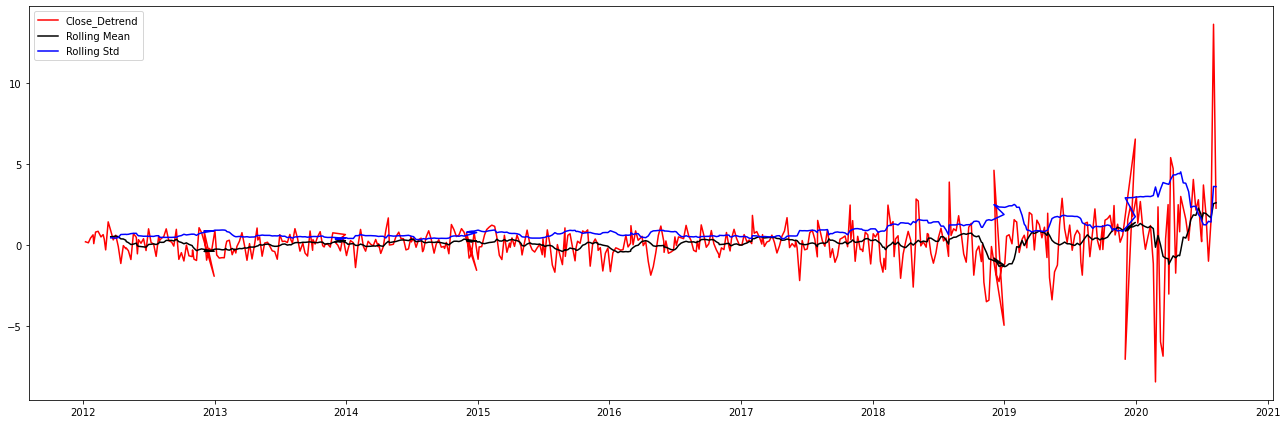

In [47]:
### apple
adfuller_test(apple_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(apple_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -7.158243880155085
                        P-value: 3.0150870029412803e-10
                       Used Lag: 18
         Number of Observations: 487
      Critical Values (for ADP): {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}
                    ResultStore: 4425.154837043934
         


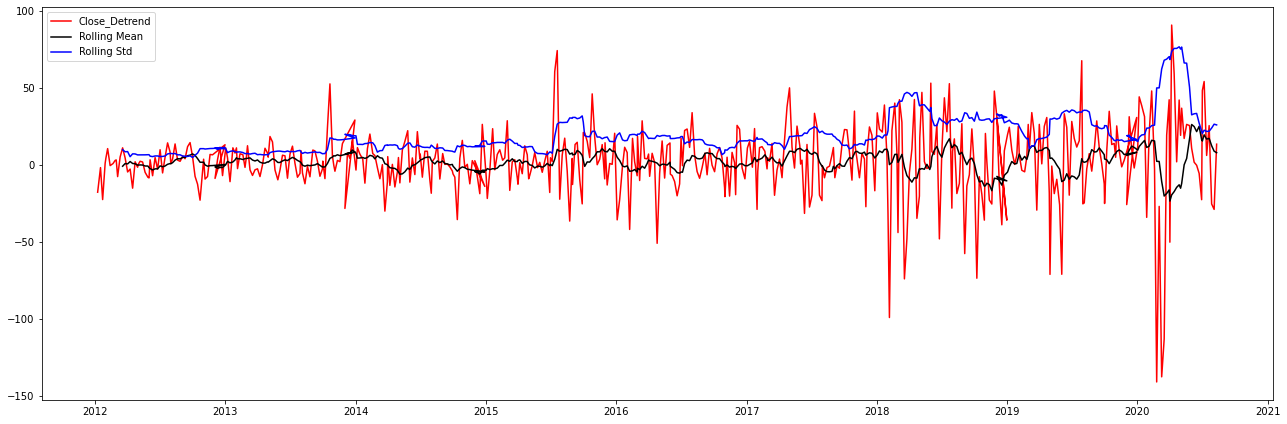

In [48]:
### google
adfuller_test(google_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(google_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -5.07350604567724
                        P-value: 1.5844581151875937e-05
                       Used Lag: 14
         Number of Observations: 490
      Critical Values (for ADP): {'1%': -3.4437660979098843, '5%': -2.8674565460819896, '10%': -2.569921291128696}
                    ResultStore: 3515.303351402727
         


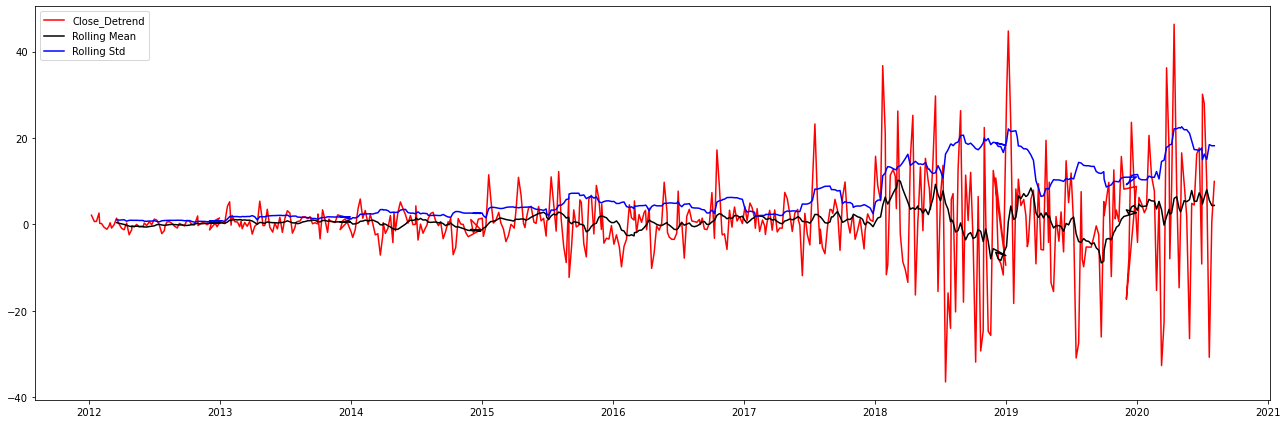

In [49]:
### netflix
adfuller_test(netflix_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(netflix_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -11.262477982322745
                        P-value: 1.6093016343221116e-20
                       Used Lag: 2
         Number of Observations: 481
      Critical Values (for ADP): {'1%': -3.4440184853599876, '5%': -2.867567599912013, '10%': -2.5699804779975883}
                    ResultStore: 2696.3295008691302
         


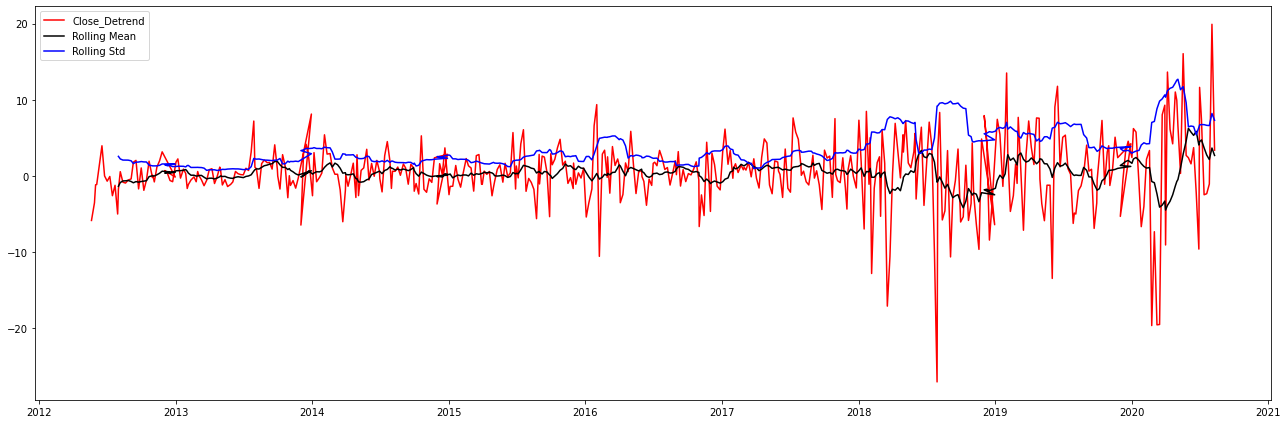

In [50]:
### facebook
adfuller_test(facebook_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(facebook_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')

-All p-values given from the Dickey-Fuller test for the 'detrended' datasets are smaller than 0.05, so we can reject the null hypothesis, and determine the time series' are stationary.

# Model

##### Creating function to train/test/split data and run ARIMA model

In [51]:
def arima_time_series(series, p, d, q, size_param=0.8):
    '''
    This function takes in a series and uses it to forecast future values
    using ARIMA modeling.

    Args:
    * series: series needed for ARIMA model function
    * p: set autoregressive order
    * d: set seasonal diff
    * q: set seasonal moving average
    * size_param: setting 0.8 train size as default

    Returns:
    * pred_obs_df: dataframe showing predicted and expected values,
                    as well as a 95% confidence interval for each step.
    '''
    # The following block is modified from Jason Brown Lee's blog 'Machine Learning Mastery'
    # split into train and test sets
    X = series.values
    size = int(len(X) * size_param)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast(steps=len(test), alpha=0.05)
    
    # plot forecasts against actual outcomes
    plt.plot(test[0:51])
    plt.title('Confidence Interval and Expected')
    plt.xlabel('Period')
    plt.ylabel('Price')
    plt.plot(output[0][0:51], color='red')
    ci_low = [x[0] for x in output[2]]
    ci_high = [x[1] for x in output[2]]
    plt.plot(ci_low[0:51], color='red')
    plt.plot(ci_high[0:51], color='red')
    plt.legend(['Expected', 'Confidence Interval'], loc='upper left')
    plt.show()
    pred_obs_df = pd.DataFrame({'predicted':output[0], 
                                'expected':test,
                               'ci low':[x[0] for x in output[2]],
                               'ci high':[x[1] for x in output[2]]})
    return pred_obs_df

#### Amazon model

##### Plotting ACF and PACF

In [52]:
amazon_series = amazon_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

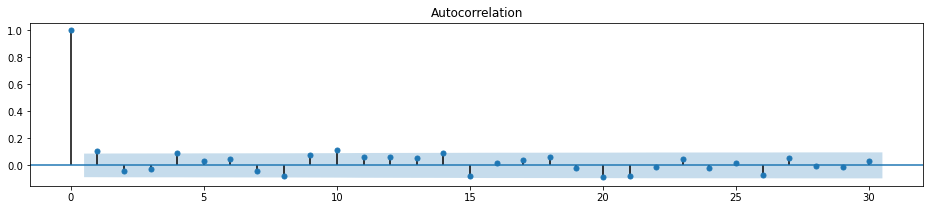

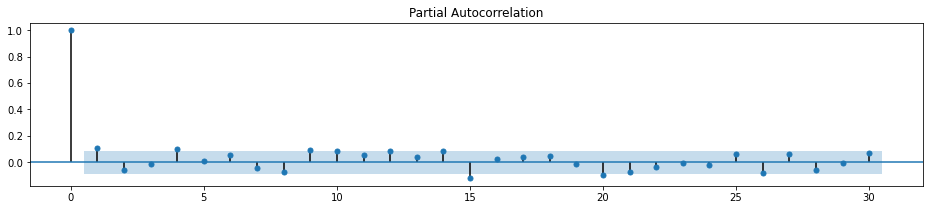

In [53]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(amazon_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(amazon_series, ax=ax, lags=30);

##### ARIMA Model

In [54]:
resampled_amazon_series = df_amazon_week_sample['Close'].dropna()
resampled_amazon_series

Date
2012-01-09     179.063999
2012-01-16     178.147495
2012-01-23     188.513998
2012-01-30     191.128000
2012-02-06     185.288000
                 ...     
2020-07-20    3050.316016
2020-07-27    3057.773975
2020-08-03    3072.461963
2020-08-10    3176.895996
2020-08-17    3137.987488
Freq: W-MON, Name: Close, Length: 450, dtype: float64

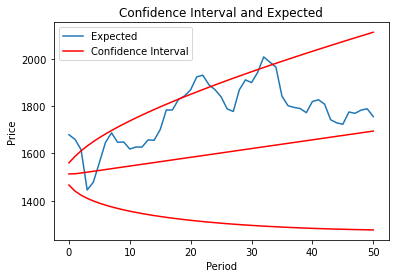

In [100]:
amazon_rs_output = arima_time_series(resampled_amazon_series, 1, 1, 0)

In [101]:
amazon_rs_output.head(53)

,predicted,expected,ci low,ci high
0,1513.357965,1679.054004,1466.425253,1560.290677
1,1514.193509,1659.437500,1440.852872,1587.534146
2,1517.312838,1615.596020,1423.654256,1610.971420
3,1520.890786,1445.759961,1410.394478,1631.387094
4,1524.560832,1478.132507,1399.437318,1649.684345
5,1528.249372,1561.077515,1390.031598,1666.467146
6,1531.941626,1645.997998,1381.765815,1682.117437
7,1535.634626,1686.940002,1374.384920,1696.884332
8,1539.327776,1647.116016,1367.717241,1710.938311
9,1543.020956,1648.516016,1361.640453,1724.401459


In [57]:
### Expected Starting [0] week = 1679.054004
### Predicted Conf_Int = 1276.159723 to 2127.496305
### ROI of Conf_Int = -24% to 25.4%

In [58]:
# creating score_diff column to calculate MAPE
amazon_rs_output['Score_diff'] = amazon_rs_output['predicted'].sub(amazon_rs_output['expected'], axis = 0)
print("\nDifference of predicted and expected :\n", amazon_rs_output)

# summing score_diff to calculate MAPE
amazon_score_col = amazon_rs_output.groupby('Score_diff').apply(lambda x: np.sum(np.abs(x)))

#
amazon_score_col.sum(axis=0, skipna=True)


Difference of predicted and expected :
       predicted     expected       ci low      ci high   Score_diff
0   1513.357965  1679.054004  1466.425253  1560.290677  -165.696039
1   1514.193509  1659.437500  1440.852872  1587.534146  -145.243991
2   1517.312838  1615.596020  1423.654256  1610.971420   -98.283182
3   1520.890786  1445.759961  1410.394478  1631.387094    75.130825
4   1524.560832  1478.132507  1399.437318  1649.684345    46.428324
..          ...          ...          ...          ...          ...
85  1823.703200  3050.316016  1280.563270  2366.843130 -1226.612816
86  1827.396387  3057.773975  1281.090891  2373.701884 -1230.377587
87  1831.089575  3072.461963  1281.636749  2380.542400 -1241.372388
88  1834.782762  3176.895996  1282.200534  2387.364990 -1342.113234
89  1838.475949  3137.987488  1282.781941  2394.169958 -1299.511539

[90 rows x 5 columns]


predicted     150676.093921
expected      178719.592967
ci low        117219.768921
ci high       184132.418920
Score_diff     28286.617346
dtype: float64

In [59]:
### Test RMSE = 50.672
### Test MAPE = 0.0235 or 2.35%

#### Apple Model

##### Plotting ACF and PACF

In [60]:
apple_series = apple_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

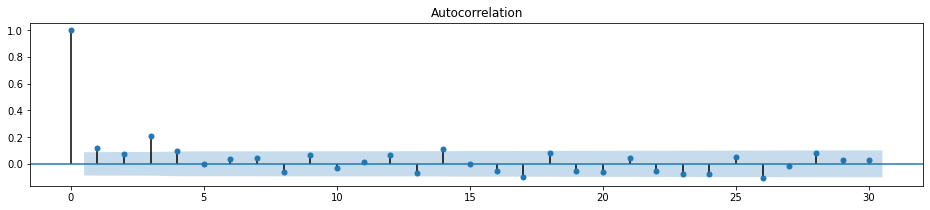

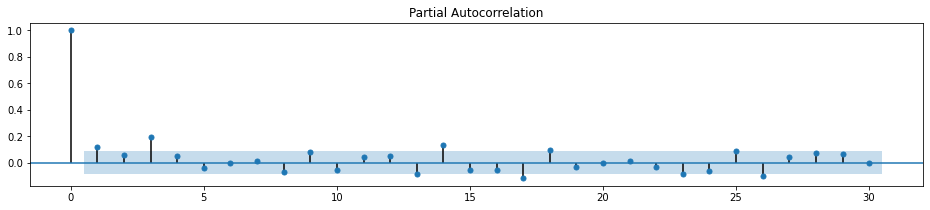

In [61]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(apple_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(apple_series, ax=ax, lags=30);

##### ARIMA Model

In [62]:
resampled_apple_series = df_apple_week_sample['Close'].dropna()
resampled_apple_series

Date
2012-01-09     14.905929
2012-01-16     15.062411
2012-01-23     15.209072
2012-01-30     15.799928
2012-02-06     16.367428
                 ...    
2020-08-10    111.494000
2020-08-17    113.382001
2020-08-24    119.954500
2020-08-31    126.040999
2020-09-07    134.179993
Freq: W-MON, Name: Close, Length: 453, dtype: float64

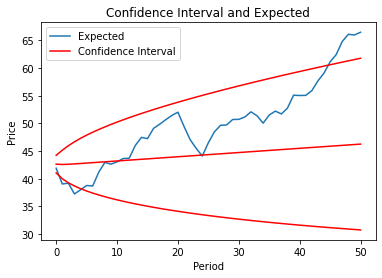

In [63]:
apple_rs_output = arima_time_series(resampled_apple_series, 1, 1, 0)

In [64]:
apple_rs_output.head(53)

,predicted,expected,ci low,ci high
0,42.653093,41.905000,41.066001,44.240184
1,42.587866,39.067500,40.017901,45.157832
2,42.625366,39.205624,39.280957,45.969775
3,42.690973,37.268749,38.702786,46.679161
4,42.764272,38.007500,38.218401,47.310143
5,42.839674,38.793126,37.796375,47.882974
6,42.915653,38.699000,37.419499,48.411807
7,42.991789,41.207000,37.077286,48.906292
8,43.067968,42.960000,36.762795,49.373140
9,43.144159,42.643125,36.471145,49.817173


In [65]:
### Expected Starting [0] week = 41.905000
### Predicted Conf_Int = 30.615231 to 62.225883
### ROI of Conf_Int = -26.9% to 48.5%

In [66]:
apple_rs_output['Score_diff'] = apple_rs_output['predicted'].sub(apple_rs_output['expected'], axis = 0)
print("\nDifference of predicted and expected :\n", apple_rs_output)

apple_score_col = apple_rs_output.groupby('Score_diff').apply(lambda x: np.sum(np.abs(x)))


Difference of predicted and expected :
     predicted    expected     ci low    ci high  Score_diff
0   42.653093   41.905000  41.066001  44.240184    0.748092
1   42.587866   39.067500  40.017901  45.157832    3.520366
2   42.625366   39.205624  39.280957  45.969775    3.419742
3   42.690973   37.268749  38.702786  46.679161    5.422224
4   42.764272   38.007500  38.218401  47.310143    4.756772
..        ...         ...        ...        ...         ...
86  49.011198  111.494000  28.710407  69.311990  -62.482802
87  49.087394  113.382001  28.669361  69.505427  -64.294607
88  49.163589  119.954500  28.628984  69.698194  -70.790911
89  49.239785  126.040999  28.589265  69.890304  -76.801214
90  49.315980  134.179993  28.550193  70.081766  -84.864013

[91 rows x 5 columns]


In [67]:
apple_score_col = apple_rs_output.groupby('Score_diff').apply(lambda x: np.sum(np.abs(x)))
apple_score_col

,predicted,expected,ci low,ci high,Score_diff
Score_diff,,,,,
-84.864013,49.315980,134.179993,28.550193,70.081766,84.864013
-76.801214,49.239785,126.040999,28.589265,69.890304,76.801214
-70.790911,49.163589,119.954500,28.628984,69.698194,70.790911
-64.294607,49.087394,113.382001,28.669361,69.505427,64.294607
-62.482802,49.011198,111.494000,28.710407,69.311990,62.482802
...,...,...,...,...,...
3.520366,42.587866,39.067500,40.017901,45.157832,3.520366
4.046548,42.839674,38.793126,37.796375,47.882974,4.046548
4.216653,42.915653,38.699000,37.419499,48.411807,4.216653


In [68]:
apple_score_col.sum(axis=0, skipna=True)

predicted     4176.002271
expected      5865.362861
ci low        2914.521982
ci high       5437.482560
Score_diff    1747.073846
dtype: float64

In [69]:
### RMSE = 2.729
### Test MAPE = 0.02328 or 2.33%

#### Google Model

In [70]:
google_series = google_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

##### Plotting ACF and PACF

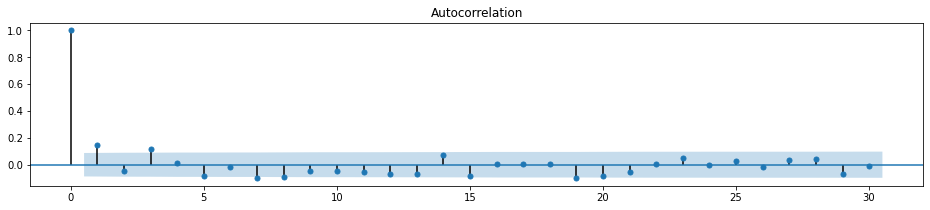

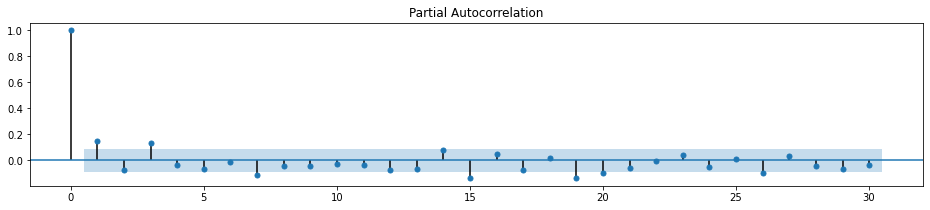

In [71]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(google_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(google_series, ax=ax, lags=30);

##### ARIMA Model

In [72]:
resampled_google_series = df_google_week_sample['Close'].dropna()
resampled_google_series

Date
2012-01-09     326.844842
2012-01-16     313.279533
2012-01-23     307.564563
2012-01-30     287.906903
2012-02-06     295.442444
                 ...     
2020-08-10    1490.505981
2020-08-17    1505.060010
2020-08-24    1567.471997
2020-08-31    1629.492017
2020-09-07    1645.797486
Freq: W-MON, Name: Close, Length: 453, dtype: float64

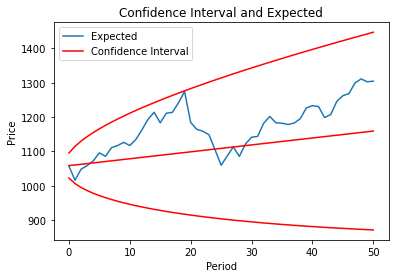

In [73]:
google_rs_output = arima_time_series(resampled_google_series, 1, 1, 0)

In [74]:
google_rs_output.head(53)

,predicted,expected,ci low,ci high
0,1058.686739,1057.256006,1022.225781,1095.147696
1,1060.369892,1015.673999,1006.228901,1114.510883
2,1062.353354,1048.097504,994.817659,1129.889048
3,1064.366154,1058.535004,985.666476,1143.065833
4,1066.381822,1072.365991,977.914443,1154.849201
5,1068.397769,1095.610016,971.138625,1165.656914
6,1070.413744,1085.682007,965.094193,1175.733294
7,1072.429721,1110.796021,959.624249,1185.235193
8,1074.445699,1117.034009,954.621071,1194.270327
9,1076.461676,1126.259979,950.006908,1202.916444


In [75]:
### Expected Starting [0] week = 1057.256006
### Predicted Conf_Int = 869.543395 to 1456.754033
### ROI of Conf_Int = -17.8% to 37.8%

In [76]:
google_rs_output['Score_diff'] = google_rs_output['predicted'].sub(google_rs_output['expected'], axis = 0)
print("\nDifference of predicted and expected :\n", google_rs_output)

google_score_col = google_rs_output.groupby('Score_diff').apply(lambda x: np.sum(np.abs(x)))
google_score_col


Difference of predicted and expected :
       predicted     expected       ci low      ci high  Score_diff
0   1058.686739  1057.256006  1022.225781  1095.147696    1.430733
1   1060.369892  1015.673999  1006.228901  1114.510883   44.695893
2   1062.353354  1048.097504   994.817659  1129.889048   14.255850
3   1064.366154  1058.535004   985.666476  1143.065833    5.831151
4   1066.381822  1072.365991   977.914443  1154.849201   -5.984169
..          ...          ...          ...          ...         ...
86  1231.691953  1490.505981   855.232716  1608.151189 -258.814029
87  1233.707930  1505.060010   855.086188  1612.329672 -271.352079
88  1235.723908  1567.471997   854.951941  1616.495874 -331.748089
89  1237.739885  1629.492017   854.829769  1620.650002 -391.752131
90  1239.755863  1645.797486   854.719470  1624.792256 -406.041623

[91 rows x 5 columns]


,predicted,expected,ci low,ci high,Score_diff
Score_diff,,,,,
-406.041623,1239.755863,1645.797486,854.719470,1624.792256,406.041623
-391.752131,1237.739885,1629.492017,854.829769,1620.650002,391.752131
-333.910003,1181.292512,1515.202515,863.645090,1498.939935,333.910003
-331.748089,1235.723908,1567.471997,854.951941,1616.495874,331.748089
-309.615485,1183.308490,1492.923974,863.101132,1503.515848,309.615485
...,...,...,...,...,...
44.695893,1060.369892,1015.673999,1006.228901,1114.510883,44.695893
49.113314,1108.717318,1059.604004,903.493835,1313.940801,49.113314
63.164354,1193.388378,1130.224024,860.676661,1526.100094,63.164354


In [77]:
google_score_col.sum(axis=0, skipna=True)

predicted     104562.763999
expected      115561.174017
ci low         81066.692598
ci high       128058.835400
Score_diff     11824.082712
dtype: float64

In [78]:
### RMSE = 35.496
### Test MAPE = 0.0209 or 2.1%

#### Netflix Model

In [79]:
netflix_series = netflix_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

##### Plotting ACF and PACF

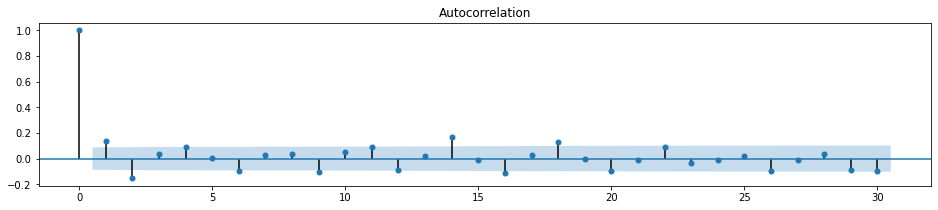

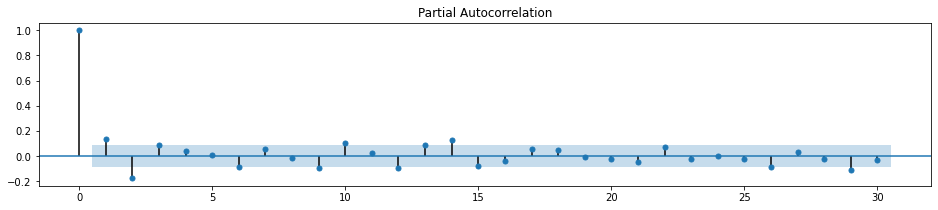

In [80]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(netflix_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(netflix_series, ax=ax, lags=30);

##### ARIMA Model

In [81]:
resampled_netflix_series = df_netflix_week_sample['Close'].dropna()
resampled_netflix_series

Date
2012-01-09     11.898857
2012-01-16     13.375357
2012-01-23     14.026286
2012-01-30     15.798286
2012-02-06     17.795714
                 ...    
2020-07-06    477.845009
2020-07-13    515.585999
2020-07-20    514.186005
2020-07-27    486.720001
2020-08-03    489.258002
Freq: W-MON, Name: Close, Length: 448, dtype: float64

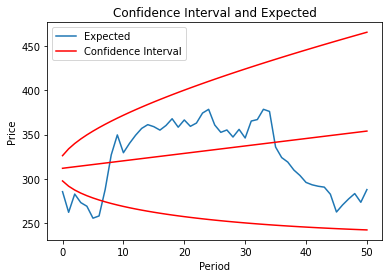

In [82]:
netflix_rs_output = arima_time_series(resampled_netflix_series, 1, 1, 0)

In [83]:
netflix_rs_output.head(53)

,predicted,expected,ci low,ci high
0,311.952761,285.600000,297.699644,326.205879
1,312.822407,262.340004,291.758234,333.886581
2,313.663569,282.891998,287.439617,339.887520
3,314.502219,273.262505,283.973592,345.030846
4,315.340648,269.171997,281.043048,349.638248
5,316.179058,255.711996,278.487467,353.870648
6,317.017465,258.244999,276.213214,357.821717
7,317.855873,287.942505,274.160132,361.551614
8,318.694281,327.083996,272.286860,365.101702
9,319.532688,349.580009,270.563518,368.501859


In [84]:
### Expected Starting [0] week = 285.600000
### Predicted Conf_Int = 241.987525 to 469.180910
### ROI of Conf_Int = -15.3% to 64.3%

In [85]:
netflix_rs_output['Score_diff'] = netflix_rs_output['predicted'].sub(netflix_rs_output['expected'], axis = 0)
print("\nDifference of predicted and expected :\n", netflix_rs_output)

netflix_score_col = netflix_rs_output.groupby('Score_diff').apply(lambda x: np.sum(np.abs(x)))
netflix_score_col


Difference of predicted and expected :
      predicted    expected      ci low     ci high  Score_diff
0   311.952761  285.600000  297.699644  326.205879   26.352761
1   312.822407  262.340004  291.758234  333.886581   50.482403
2   313.663569  282.891998  287.439617  339.887520   30.771570
3   314.502219  273.262505  283.973592  345.030846   41.239714
4   315.340648  269.171997  281.043048  349.638248   46.168651
..         ...         ...         ...         ...         ...
85  383.251670  477.845009  238.451364  528.051976  -94.593339
86  384.090078  515.585999  238.448533  529.731622 -131.495921
87  384.928485  514.186005  238.450534  531.406437 -129.257520
88  385.766893  486.720001  238.457283  533.076503 -100.953108
89  386.605301  489.258002  238.468701  534.741900 -102.652701

[90 rows x 5 columns]


,predicted,expected,ci low,ci high,Score_diff
Score_diff,,,,,
-131.495921,384.090078,515.585999,238.448533,529.731622,131.495921
-129.257520,384.928485,514.186005,238.450534,531.406437,129.257520
-102.652701,386.605301,489.258002,238.468701,534.741900,102.652701
-100.953108,385.766893,486.720001,238.457283,533.076503,100.953108
-94.593339,383.251670,477.845009,238.451364,528.051976,94.593339
...,...,...,...,...,...
68.784591,352.230587,283.445996,243.020308,461.440866,68.784591
73.954179,351.392179,277.438001,243.306315,459.478044,73.954179
79.440998,353.068994,273.627997,242.745761,463.392228,79.440998


In [86]:
netflix_score_col.sum(axis=0, skipna=True)

predicted     31436.616835
expected      31583.126961
ci low        22493.767120
ci high       40379.466551
Score_diff     3773.120459
dtype: float64

In [87]:
### RMSE = 15.019
### Test MAPE = 0.03398 or 3.4%

#### Facebook Model

In [88]:
facebook_series = facebook_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

##### Plotting ACF and PACF

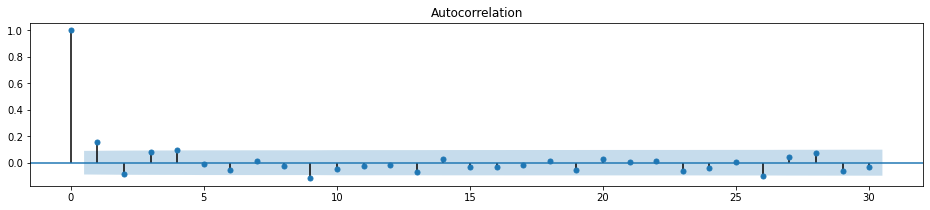

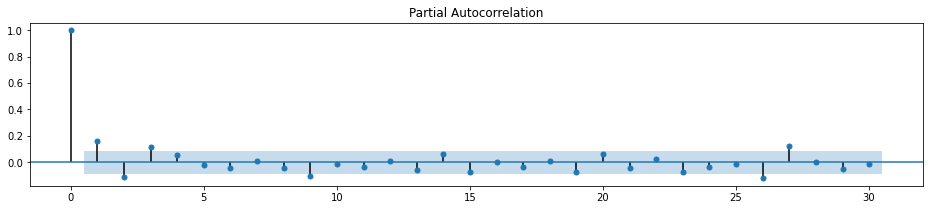

In [89]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(facebook_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(facebook_series, ax=ax, lags=30);

##### ARIMA Model

In [90]:
resampled_facebook_series = df_facebook_week_sample['Close'].dropna()
resampled_facebook_series

Date
2012-05-21     36.129999
2012-05-28     31.985000
2012-06-04     28.250000
2012-06-11     26.620000
2012-06-18     28.876000
                 ...    
2020-07-27    235.686002
2020-08-03    240.707999
2020-08-10    259.134000
2020-08-17    259.944000
2020-08-24    262.339996
Freq: W-MON, Name: Close, Length: 432, dtype: float64

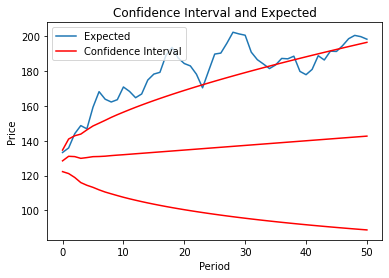

In [91]:
facebook_rs_output = arima_time_series(resampled_facebook_series, 3, 1, 0)

In [92]:
facebook_rs_output.head(53)

,predicted,expected,ci low,ci high
0,128.435167,133.247498,122.240553,134.629780
1,131.057479,135.854999,121.129214,140.985743
2,130.875942,144.029999,118.888304,142.863581
3,129.877722,148.707496,115.940407,143.815036
4,130.315744,146.836002,114.389869,146.241620
5,130.845521,159.252002,113.201187,148.489856
6,130.931619,168.230002,111.762049,150.101189
7,131.120129,163.889999,110.502222,151.738037
8,131.452369,162.279996,109.470956,153.433782
9,131.724355,163.607999,108.469608,154.979103


In [93]:
### Expected Starting [0] week = 133.247498
### Predicted Conf_Int = 88.194612 to 198.177309
### ROI of Conf_Int = -33.81% to 48.72%

In [94]:
facebook_rs_output['Score_diff'] = facebook_rs_output['predicted'].sub(facebook_rs_output['expected'], axis = 0)
print("\nDifference of predicted and expected :\n", facebook_rs_output)

facebook_score_col = facebook_rs_output.groupby('Score_diff').apply(lambda x: np.sum(np.abs(x)))
facebook_score_col


Difference of predicted and expected :
      predicted    expected      ci low     ci high  Score_diff
0   128.435167  133.247498  122.240553  134.629780   -4.812331
1   131.057479  135.854999  121.129214  140.985743   -4.797521
2   130.875942  144.029999  118.888304  142.863581  -13.154057
3   129.877722  148.707496  115.940407  143.815036  -18.829775
4   130.315744  146.836002  114.389869  146.241620  -16.520257
..         ...         ...         ...         ...         ...
82  151.196445  235.686002   82.228192  220.164698  -84.489557
83  151.463461  240.707999   82.077783  220.849139  -89.244538
84  151.730477  259.134000   81.929871  221.531084 -107.403523
85  151.997493  259.944000   81.784410  222.210576 -107.946507
86  152.264509  262.339996   81.641359  222.887660 -110.075487

[87 rows x 5 columns]


,predicted,expected,ci low,ci high,Score_diff
Score_diff,,,,,
-110.075487,152.264509,262.339996,81.641359,222.887660,110.075487
-107.946507,151.997493,259.944000,81.784410,222.210576,107.946507
-107.403523,151.730477,259.134000,81.929871,221.531084,107.403523
-91.939589,150.662413,242.602002,82.536682,218.788143,91.939589
-90.748568,150.929429,241.677997,82.381143,219.477715,90.748568
...,...,...,...,...,...
-13.939815,146.924187,160.864001,85.016338,208.832036,13.939815
-13.154057,130.875942,144.029999,118.888304,142.863581,13.154057
-4.812331,128.435167,133.247498,122.240553,134.629780,4.812331


In [95]:
facebook_score_col.sum(axis=0, skipna=True)

predicted     12249.707256
expected      16805.439980
ci low         8144.464897
ci high       16354.949615
Score_diff     4555.732724
dtype: float64

In [96]:
### RMSE = 6.754
### Test MAPE = 0.0263 or 2.63%

In [97]:
### RMSE amazon= 75.143
### RMSE apple= 2.729
### RMSE google= 35.496
### RMSE netflix= 15.019
### RMSE facebook= 6.754

### MAPE amazon= 0.0235 or 2.35%
### MAPE apple= 0.02328 or 2.33%
### MAPE google= 0.0209 or 2.1%
### MAPE netflix= 0.03398 or 3.4%
### MAPE facebook= 0.0263 or 2.63%

### MAPE VALUES TO COMPARE AND CONTRAST STOCKS

In [98]:
### Year to year ROI since 2012

### Amazon
### 11%+ for last 6 years.
### 1298% growth since 2013 start

### Apple
### 80%+ for last 2 years.
### 641% growth since 2013 start

### Google
### 28-30% 3 of last 4 years.
### 440% growth since 2013 start (prorated)

### Netflix
### 21%+ 5 of last 6 years (8.24% 'down' year)
### 584% growth since 2013 start

### Facebook
### 33%+ 3 of last 4 years
### 1026% growth since 2013 start

In [99]:
### Store predicted and expected values 
### to calculate MAPE for best model params for each stock

### Use MAPE to judge models performance against one another

# Interpret

#### Conclusion

To summarize the findings, we have identified that there seem to be no clear 'lag indicators' in the data that stick out.  There is a clear upward trend/growth for these stocks as a whole.  This makes sense, as over time the stock market as a whole has shown historical growth.  There was a non-significant but noticeable lag around quarterly/annual reporting periods. Apple stock had the safest ROI (highest floor, projected year-to-year ROI of -2.7% to 19.7%).  Facebook stock had the riskiest ROI (lowest floor, projected year-to-year ROI of -33.81% to 48.72%). Most of these stocks seem to rise and fall together, and the prices changes are highly correlated with one another.  This would suggest these stocks as a whole trend down and up together.  (Note- can't be sure if this is due to the stocks being within the same industry, natural markets, news cycle, etc.)

#### Recommendations

1. Diversify your portfolio.  Include a mix of stocks that have limited upside but low risk, with stocks that provide higher risk but also higher potential return on investment.  This will protect your investments from any huge swings an individual stock can suffer from, however, it will cap potential profits but this trade-off is recommended.  

2. Invest in Netflix.  Netflix is the clear-cut safest pick of these stocks according to the models.  Given the 95% confidence interval that Netflix will have an ROI between -15.3% and 64.3%, NFLX stock is the strongest candidate as a 'pick-one' stock if we had to choose just one; this is because they have the highest floor of the group as well as the highest ceiling.

3. Buy stocks "on-sale".  Based on the autoregressive features and cyclical nature of how the stock market operates, buying stocks that are currently on a downswing can provide better potential for high returns on investment.

#### Future Work

- Look into stocks in multiple sectors other than tech.  It would be interesting to see if there are any obvious patterns from businesses that have super seasonal revenue streams and if that has an impact on stock price.  

- Building a model that factors in product releases, news cycles, or company quarterly reports (although somewhat nuanced, could potentially be a clear indicator).  Use a mix of models somewhat like modern day stock traders that use complicated algorithms and graphical patterns to identify trends in data. 

- Identifying optimal time intervals to hold stocks.  It is almost impossible to get in stocks at the absolute lows, and out at the absolute highs to maximize profits...since all indicators are 'lagging' indicators.  This is much more important when trading stocks daily rather than identifying simple long-term stocks to buy and hold. 

- See if there is a strong link of price movement between certain stocks in the same industry and see if we can identify which 'controls' the market.  (i.e- Bitcoin moving before most other cryptos move with it...)

- Research stock investing to see what percent of trading is done by bots, and what the bots are responding to. (i.e- news data, actual AR/MA trends...what are they optimized to do)

- See if longer time series (i.e- more mature stocks) provide better predictive qualities or if new data is exponentially more important.